<a href="https://colab.research.google.com/github/vsermoud/Introduction-to-Classical-DFT/blob/main/Initial_Steps_Ideal_Gas_in_slit_like_pores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ideal Gas cDFT


### Considering that the free energy of a fluid can be modeled as an ideal gas, the cDFT equation can be rewritten as:

### $\Omega[\rho(\textbf{r})] = F_{ideal}[\rho(\textbf{r})]+\int d{\textbf{r}} \rho(\textbf{r}) (V_{ext}(\textbf{r})-\mu)$

### While $F_{ideal}$ is obtained analytically and can be described as:

### $F_{ideal}\left[\rho\left(\textbf{r}\right)\right] = \int \rho\left( \textbf{r} \right) \left[ \ln (\rho\left( \textbf{r} \right)) - 1 \right] \texttt{d} \textbf{r}$

### At equilibria

### $\left. \frac{\Omega[\rho(\textbf{r})]} {\rho(\textbf{r})} \right|_{\rho \approx \rho_{eq}} = \frac{\delta F_{ideal}[\rho(\textbf{r})]} {\rho(\textbf{r})} + V_{ext}(\textbf{r})-\mu = 0$
$\frac{\delta F_{ideal}[\rho(\textbf{r})]} {\rho(\textbf{r})} = \mu - V_{ext}(\textbf{r})$

### with

### $\frac{\delta F_{ideal}[\rho(\textbf{r})]} {\rho(\textbf{r})} = k_BT \ln (\rho(\textbf{r})\sigma^3)$
### Considering that the chemical potential is the same at every point in the pore, at equilibrium. We can calculate the chemical potential from the constant density of the bulk ($rho_b$)
### $\mu = k_BT \ln (\rho_{b}\sigma^3 ) $

### Which give us:
### $k_BT \ln (\rho(\textbf{r})\sigma^3) = k_BT \ln (\rho_{b}\sigma^3 ) - V_{ext}(\textbf{r})$
#### and Finally:
### $\rho(\textbf{r}) = \rho_{b} \exp \left(- \frac{V_{ext}(\textbf{r})}{k_BT} \right)$

### This expression allows the density to be described explicitly, depending on the interaction of the fluid with the wall, described by $V_{ext}(\textbf{r})$, and its condition in the volumetric phase described by Temperature (T) and $\rho_b$. So, to continue with this calculation, it is interesting to calculate $\rho_b$ from the ideal gas equation of state, given a $P$ and $T$, even though modern isotherm evaluation equipment can already provide measured bulk density data.

### From the ideal gas equation of state:

### $P \bar{V} = k_BT$
### $P \frac{1}{\rho_b} = k_BT$

### $\rho_b = \frac{P}{k_BT}$

### in which $P$ is the volumar pressures outside of the pore.

### External potential and simulation box

### In the case of an ideal gas, the local variation in density depends on a locally varying value of the external potential. Therefore, without this potential, the density value is constant and equal to the bulk density.

### To show the implementation of a simulation box, we will demonstrate the simulation of an ideal gas confined in a slit-type pore.



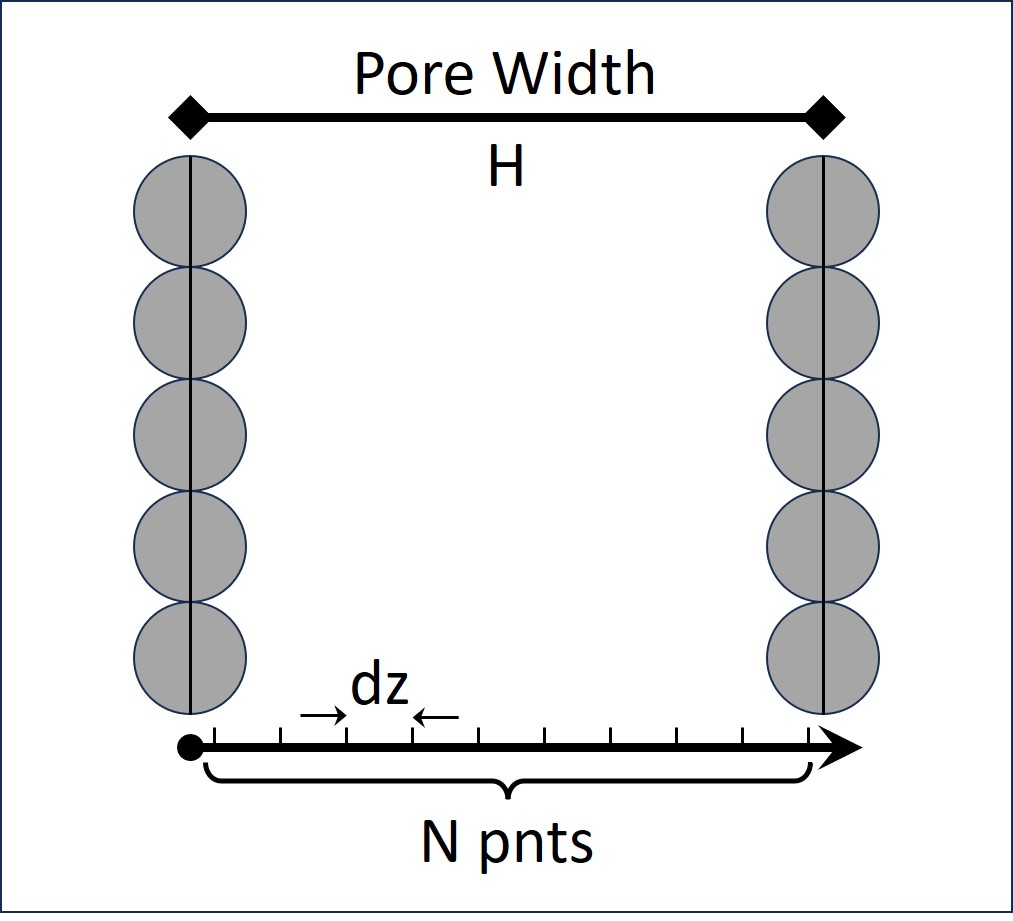

### In this case, as the pore is made up of two flat, infinite slabs, the external potential will only vary in the direction normal to the plane of the wall, making it possible to use one-dimensional models.

### Here, to simulate the slit-like pore interaction with the fluid molecules we are going to use the Steele potential (10-4), described as

### $ \phi_{ext}(z) = \epsilon_{eff}\left(\frac{2}{5}\left(\frac{\sigma_{sf}}{z}\right)^{10}-\left(\frac{\sigma_{sf}}{z}\right)^4\right)$

### This potential has two parameters, $\sigma_{sf}$  and  $\epsilon_{eff}$, and depends on the distance, z, between the center of the fluid-solid molecules. Since the fluid is described as an ideal gas, $\sigma_{sf}$ is the solid molecule radius. In the following sections, after adding hard-sphere and dispersive potentials, $\sigma_{sf}$ can be obtained by the Lorentz-Berthelot mixing rule.



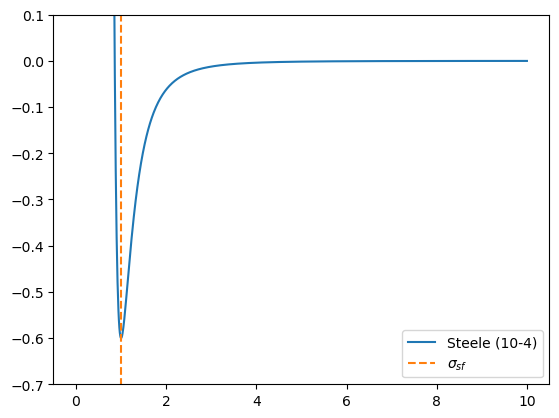

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

dist_vec = np.linspace(0,10,1000)

def Steele_10_4(E_eff,Sigma_sf,dist):
    Phi = np.zeros((len(dist)))
    for i in range(len(dist)):
        if dist[i] != 0:
            Phi[i] =  E_eff*(0.4*(Sigma_sf/dist[i])**10-(Sigma_sf/dist[i])**4)
        elif dist[i] == 0:
            Phi[i] = 1e20
    return Phi

plt.plot(dist_vec,Steele_10_4(1.,1.,dist_vec), label="Steele (10-4)")
plt.plot(np.zeros((1000))+1.,np.linspace(-1,1,1000),linestyle = "--", label = "$\sigma_{sf}$")
#plt.plot(np.linspace(-1,1,1000),np.zeros((1000))-1.,linestyle = ".-", label = "$\sigma_{sf}$")
plt.ylim(-0.7,0.1)
plt.legend()
plt.show()

### The figure below shows the dependency of the model on $\sigma_{sf}$:

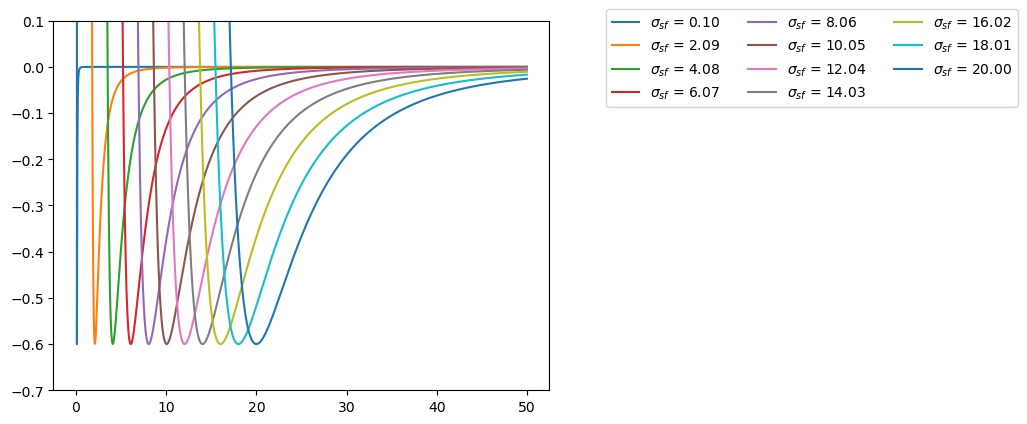

In [ ]:
dist_vec = np.linspace(0,50,1000)

sigma_vec = np.linspace(0.1,20,11)

for i in range(11):
    plt.plot(dist_vec,Steele_10_4(1.,sigma_vec[i],dist_vec), label="$\sigma_{sf}$ = "+str('{:,.2f}'.format(sigma_vec[i])))
plt.ylim(-0.7,0.1)
plt.legend(ncol=3,bbox_to_anchor=(1.1, 1.05))
plt.show()

### The figure below shows the dependency of the model on $\epsilon_{eff}$:

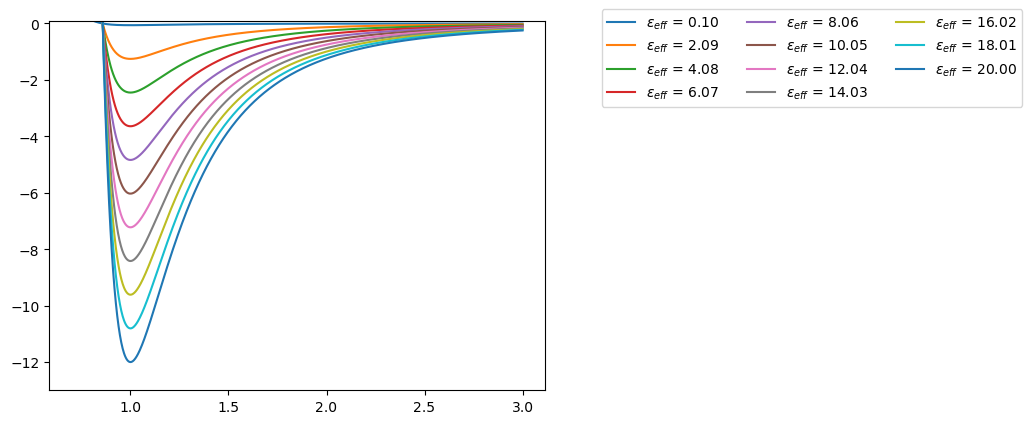

In [ ]:
dist_vec = np.linspace(0.7,3,1000)

eps_vec = np.linspace(0.1,20,11)

for i in range(11):
    plt.plot(dist_vec,Steele_10_4(eps_vec[i],1.,dist_vec), label="$\epsilon_{eff}$ = "+str('{:,.2f}'.format(eps_vec[i])))
plt.ylim(-13,0.1)
plt.legend(ncol=3,bbox_to_anchor=(1.1, 1.05))
plt.show()

### For this case study, the first step in creating our simulation box is to generate the grid inside the pore. The variables needed to generate the grid are the pore width (H), the number of grid points (N_pnts), and the resolution of our grid (dz). Two of these variables must be set when constructing the simulation box, while the third is obtained from the others. In this way, the user can select H and dz, or N_pnts and H, or N_pnts and dz, and these variables are related as follows:

### $H = N_{pnts} \times dz$

### in this way:

In [ ]:
import numpy as np
H = 10                                # [Pore width]
dz = 0.1                              # [distance between grid points]
Num_points = int(H/dz)+1              #[Number of points]

### To build the grid in python we can use the linspace function from the NumPy package

In [ ]:
Z_vec = np.linspace(0,H,Num_points)   #Grid vector

### Moreover, to check the distribution of the points along the simulation box, we can plot them using Matplotlib's pyplot.

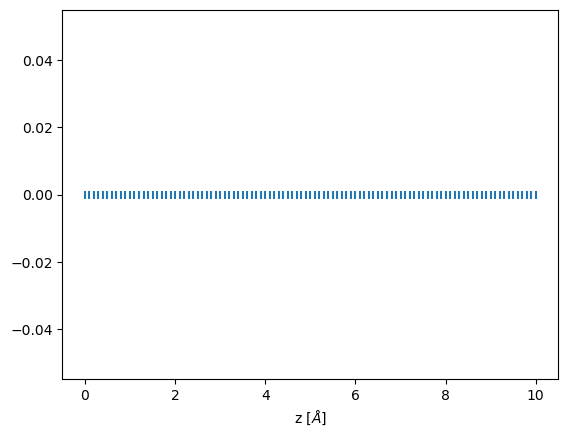

In [ ]:
from matplotlib import pyplot as plt

Y = np.zeros((len(Z_vec)))

plt.scatter(Z_vec,Y, marker = "|")
plt.xlabel("z [$\AA$]")
plt.show()

### Now that we have the wall potential and the grid representing the positions inside the pore, we can add a wall at the first and last points of the grid to generate the external potential. In this way, the external potential will consider the molecule's interaction with both walls, one of the distinguishing features of cDFT modeling.

### Then the external potential will be obtained by adding the potentials of the two walls. Considenring that the first wall is positioned in $z = 0$, and the second wall in the position $z = H$, the External potential ($V_{ext}$) can be writed as:

### $V_{ext}(z) = \phi_{ext}(z)+\phi_{ext}(H-z)$

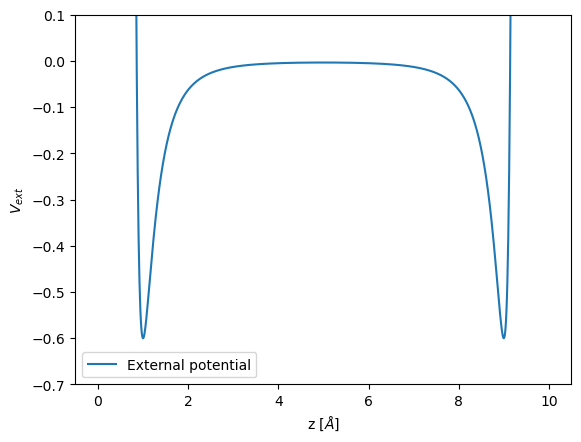

In [ ]:
H = 10
dz = 0.01
nump = int(H/dz)
z_vec = np.linspace(0,H,nump)
Vext = Steele_10_4(1.,1.,z_vec)+Steele_10_4(1.,1.,H-z_vec)


plt.plot(z_vec,Vext, label="External potential")
plt.xlabel("z [$\AA$]")
plt.ylabel("$V_{ext}$")
plt.ylim(-0.7,0.1)
plt.legend()
plt.show()

## Nondimensionalization of inputs

### Depending on the variables, some can have their numerical values with large orders of magnitude, which can directly affect the convergence of the minimization methods, considering cases in which the excess part of the free energy is essential. To mitigate this, the nondimensionalization of the working variables is a strong suggestion.

### The following table shows the removal of typical variable units used in the cDFT simulation.

|Variable|Nondimensionalization|Type|
|--|--|--|
|$P^*$|$\frac{P\sigma^3}{\epsilon}$|Pressure|
|$T^*$|$\frac{T}{\epsilon/k_B}$|Temperature|
|$H^*$|$\frac{H}{\sigma}$|Length|
|$\epsilon^*$|$\frac{\epsilon}{\epsilon_{ref}}$|Interaction Potential|
|$\sigma^*$|$\frac{\sigma}{\sigma_{ref}}$|Particle diameter|

##  Ideal gas direct solution

### From the expression of the cDFT model for the ideal gas and the construction of the external potential, the local density for the ideal gas can be obtained directly from the expression:

### $\rho(z) = \rho_{b} \exp \left(- \frac{V_{ext}(z)}{k_BT} \right)$

### Given a condition of the T and P of the volume phase

In [ ]:
P = 1e5   # [Pressure - Pa]
T = 300 # [Temperature - K]

### Given the pore size and simulation boxe

In [ ]:
import numpy as np
H = 30                                # [Pore width - Angstroms]
dz = 0.03                              # [distance between grid points - Angstroms]
Num_points = int(H/dz)+1              #[Number of points]

### Solid-Fluid parameters

In [ ]:
E_eff = 1000    #Efective wall parameter [K]
Sigma_sf = 2.8 #Solid molecule parameter [Angstrom]

### Removing the dimension of the variables

In [ ]:
# references (Just an example)
Sigma = 3. #Angstrom
Epsilon = 100. #[K]
kb = 1.3806488e-23 #Boltzmann constant


#Nondimensionalization
T = T/Epsilon
P = (P/(kb*Epsilon)*(Sigma*1.e-10)**3)
E_eff = E_eff/Epsilon
Sigma_sf = Sigma_sf/Sigma
H = H/Sigma
dz = dz/Sigma

### Preparing the grid for the calculation

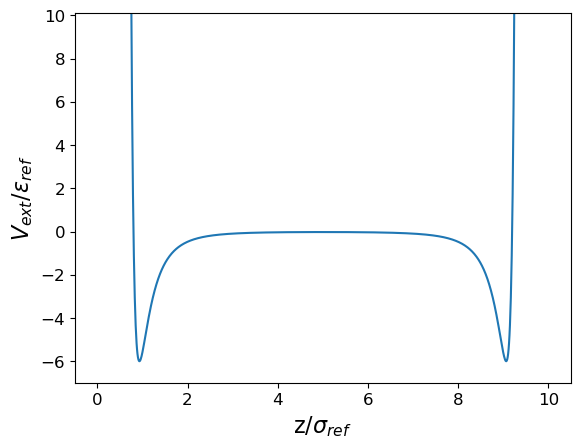

In [ ]:
#Spacial vector
Z_vec = np.linspace(0,H,Num_points)
Vext = Steele_10_4(E_eff,Sigma_sf,Z_vec)+Steele_10_4(E_eff,Sigma_sf,H-Z_vec)
plt.plot(Z_vec,Vext, label="External potential")
plt.xlabel("z/$\sigma_{ref}$",fontsize=16)
plt.ylabel("$V_{ext}/\epsilon_{ref}$",fontsize=16)
plt.ylim(-7,10.1)
#plt.legend()

# Ajustando os tamanhos das fontes nos eixos x e y
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.savefig('HowToDo/Figuras/V_ext.pdf')
plt.show()

### Calculate bulk density

In [ ]:
rho_b = P/T

rho_b

0.0006518674408727258

### And With everything ready, in the case of an ideal gas, the density can be calculated directly:

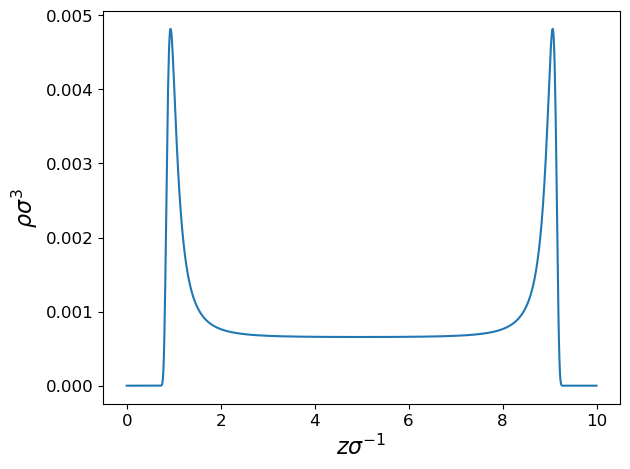

In [ ]:
#Initializing the density vector
rho_vec = rho_b*np.exp(-Vext/T)
plt.plot(Z_vec,rho_vec)
plt.ylabel(r"$\rho \sigma^3$",fontsize=16)
plt.xlabel(r"$z \sigma^{-1}$",fontsize=16)

# Ajustando os tamanhos das fontes nos eixos x e y
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()

plt.savefig('HowToDo/Figuras/Rho_id.pdf')
plt.show()

### From the density profile, it is possible to obtain the amount adsorbed in a slit-like surface:

### $\Gamma \sigma^2 = 0.5\int_0^H \rho(z) dz$

### the excess adsorption isotherm

### $\Gamma_{exc} \sigma^2 = 0.5\int_0^H (\rho(z)-\rho_b) dz$

### The factor 0.5 is due to the division of the amount adsorbed by the two walls, resulting in an amount adsorbed per area.

In [ ]:
from scipy import integrate

Nads = 0.5*integrate.trapz(rho_vec,Z_vec)
Nexc = 0.5*integrate.trapz(rho_vec-rho_b,Z_vec)

### With $\Gamma \sigma^2$ it is possible to built an adsorption isotherm

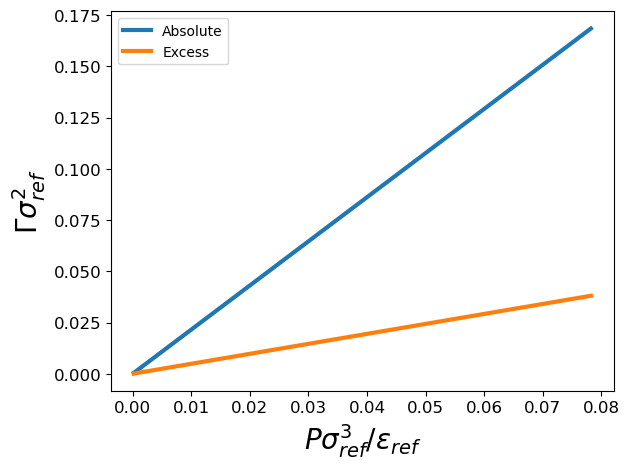

In [ ]:
import numpy as np

T = 300 #[K]
T = T/Epsilon
P_vec = np.linspace(1e4,40e5,100) #[Pa]
P_vec = ((P_vec)/(kb*Epsilon)*(Sigma*1.e-10)**3) #[Pa]

Nads = np.zeros((len(P_vec)))
Nexc = np.zeros((len(P_vec)))
for i in range(len(P_vec)):
    #Calculating the ideal contribution of the Chemical potential
    rho_homog = P_vec[i]/T
    rho_vec = rho_homog*np.exp(-Vext/T)
    Nads[i] = 0.5*integrate.trapz(rho_vec,Z_vec)
    Nexc[i] = 0.5*integrate.trapz(rho_vec-rho_homog,Z_vec)

#P_vec = np.linspace(0.1,40,100) #[bar]

plt.plot(P_vec,Nads, linewidth=3,label="Absolute")
plt.plot(P_vec,Nexc, linewidth=3,label="Excess")
#plt.xlabel("Pressure [bar]", fontsize=20)
plt.xlabel("$P\sigma_{ref}^3/\epsilon_{ref}$", fontsize=20)
plt.ylabel(r"$\Gamma \sigma_{ref}^2$", fontsize=20)

# Ajustando os tamanhos das fontes nos eixos x e y
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()


plt.legend()
plt.savefig('HowToDo/Figuras/Isotherms_ID.pdf')

plt.show()

### Dependence with the temperature

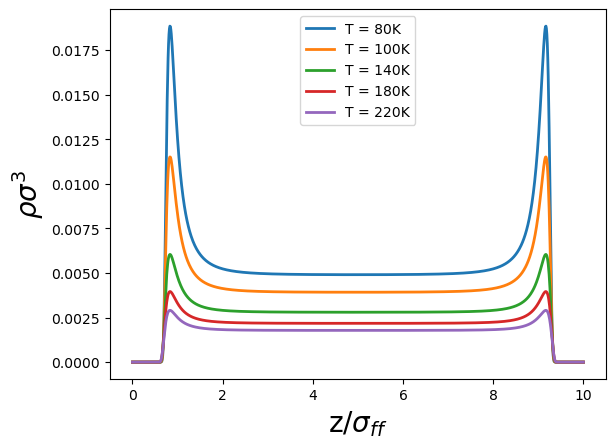

In [ ]:
T_vec = [80,100,140,180,220]
P_vec = 2 #[bar]
P_vec = ((P_vec*1.e5)/(kb*Epsilon)*(Sigma*1.e-10)**3) #[Pa]

E_eff = 20/Epsilon*(Sigma*Sigma) #K/A^2
Sigma_sf = 2.5/Sigma

Vext = Steele_10_4(E_eff,Sigma_sf,Z_vec)+Steele_10_4(E_eff,Sigma_sf,H-Z_vec)

rho_vec_H = np.zeros((len(Vext)))

for j in range(len(T_vec)):
    T_vec[j] = T_vec[j]/Epsilon
    rho_homog = P_vec/T_vec[j]
    #rho_vec = rho_homog*np.exp(-Vext/T_vec[j])
    rho_vec = rho_homog*np.exp(-Vext/T_vec[j])
    rho_vec_H[:] = rho_homog
    T_vec = [80,100,140,180,220]
    plt.plot(Z_vec,rho_vec, linewidth=2,label = "T = "+str('{:,.0f}'.format(T_vec[j]))+"K")
    #plt.plot(Z_vec,rho_vec_H, linewidth=3)
plt.xlabel(r"z/$\sigma_{ff}$", fontsize=20)
plt.ylabel(r"$\rho \sigma^3$", fontsize=20)
plt.legend()
plt.show()

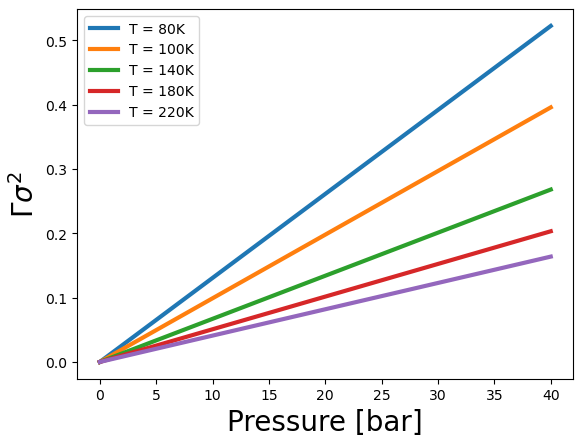

In [ ]:
T_vec = [80,100,140,180,220]
T_vecA = np.zeros((5))
P_vec = np.linspace(0.001,40,100) #[bar]
P_vecA = ((P_vec*1.e5)/(kb*Epsilon)*(Sigma*1.e-10)**3) #[Pa]

for j in range(len(T_vec)):
    T_vecA[j] = T_vec[j]/Epsilon
    rho_vec = np.zeros((len(Vext)))
    Nads = np.zeros((len(P_vec)))
    for i in range(len(P_vec)):
        #Calculating the ideal contribution of the Chemical potential
        rho_homog = P_vecA[i]/T_vecA[j]
        rho_vec = rho_homog*np.exp(-Vext/T_vecA[j])
        Nads[i] = 0.5*integrate.trapz(rho_vec,Z_vec)
    plt.plot(P_vec,Nads, linewidth=3,label = "T = "+str('{:,.0f}'.format(T_vec[j]))+"K")
plt.xlabel("Pressure [bar]", fontsize=20)
plt.ylabel(r"$\Gamma \sigma^2$", fontsize=20)
plt.legend()
plt.show()